In [1]:
import pandas as pd
import numpy as np
from sksurv.nonparametric import kaplan_meier_estimator as kmf
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test
import matplotlib.patches as mpatches
from lifelines import CoxPHFitter

In [2]:
cell_type = 'Vascular and lymphatic'
path = "../data/brca/tcga/processed/GSE161529/weights_cell_type_tumor.csv"
cell_estimation = pd.read_csv(path,sep=',')
cell_estimation.head()

,Vascular and lymphatic,BA,HS,Fibroblast,AV,Immune
E2-A1IU,0.605655,0.0,0.0,0.003448,0.0,0.390897
AO-A03U,0.544643,0.0,0.0,0.004960,0.0,0.450398
E9-A1NH,0.459993,0.0,0.0,0.054763,0.0,0.485244
BH-A1EY,0.259348,0.0,0.0,0.032059,0.0,0.708593
AO-A1KS,0.440002,0.0,0.0,0.021159,0.0,0.538839


In [3]:
path = "../data/brca/tcga/processed/GSE161529/clinical_cell_type_tumor.csv"
survival = pd.read_csv(path,sep=',')
survival = survival.set_index(survival.patientId)
survival.head()

,patientId,SUBTYPE,AJCC_PATHOLOGIC_TUMOR_STAGE,RADIATION_THERAPY,WINTER_HYPOXIA_SCORE,OS_MONTHS,OS_STATUS,DFS_MONTHS,DFS_STATUS
patientId,,,,,,,,,
3C-AAAU,3C-AAAU,BRCA_LumA,STAGE X,No,-28.0,133.050597,0:LIVING,59.440444,1:Recurred/Progressed
3C-AALI,3C-AALI,BRCA_Her2,STAGE IIB,Yes,20.0,131.669790,0:LIVING,131.669790,0:DiseaseFree
3C-AALJ,3C-AALJ,BRCA_LumB,STAGE IIB,No,-10.0,48.459743,0:LIVING,48.459743,0:DiseaseFree
3C-AALK,3C-AALK,BRCA_LumA,STAGE IA,No,4.0,47.604958,0:LIVING,NaN,NaN
4H-AAAK,4H-AAAK,BRCA_LumA,STAGE IIIA,No,-20.0,11.440971,0:LIVING,11.440971,0:DiseaseFree


In [4]:
survival_test = cell_estimation.merge(survival,left_index=True,right_index=True,how='inner')
survival_test.head()

,Vascular and lymphatic,BA,HS,Fibroblast,AV,Immune,patientId,SUBTYPE,AJCC_PATHOLOGIC_TUMOR_STAGE,RADIATION_THERAPY,WINTER_HYPOXIA_SCORE,OS_MONTHS,OS_STATUS,DFS_MONTHS,DFS_STATUS
E2-A1IU,0.605655,0.0,0.0,0.003448,0.0,0.390897,E2-A1IU,BRCA_LumA,STAGE IA,No,-26.0,11.079331,0:LIVING,11.079331,0:DiseaseFree
AO-A03U,0.544643,0.0,0.0,0.004960,0.0,0.450398,AO-A03U,BRCA_Normal,STAGE I,No,-26.0,58.947299,1:DECEASED,58.947299,0:DiseaseFree
E9-A1NH,0.459993,0.0,0.0,0.054763,0.0,0.485244,E9-A1NH,BRCA_LumA,STAGE IIB,No,-10.0,18.936779,0:LIVING,18.936779,0:DiseaseFree
BH-A1EY,0.259348,0.0,0.0,0.032059,0.0,0.708593,BH-A1EY,BRCA_LumA,STAGE IIA,No,-28.0,17.687477,1:DECEASED,NaN,NaN
AO-A1KS,0.440002,0.0,0.0,0.021159,0.0,0.538839,AO-A1KS,BRCA_LumB,STAGE IIA,Yes,-18.0,11.506723,0:LIVING,11.506723,0:DiseaseFree


In [5]:
survival_test = survival_test.rename({"DFS_MONTHS": "DFS", 
                                      "OS_MONTHS":"OS",
                                      "OS_STATUS":"OS_E",
                                      "DFS_STATUS":"DFS_E",
                                     }, axis=1)
survival_test['OS_E'] = survival_test['OS_E'].str.split(':').str[0]
survival_test['DFS_E'] = survival_test['DFS_E'].str.split(':').str[0]
survival_test = survival_test.drop(["patientId"], axis=1)
survival_test.head()

,Vascular and lymphatic,BA,HS,Fibroblast,AV,Immune,SUBTYPE,AJCC_PATHOLOGIC_TUMOR_STAGE,RADIATION_THERAPY,WINTER_HYPOXIA_SCORE,OS,OS_E,DFS,DFS_E
E2-A1IU,0.605655,0.0,0.0,0.003448,0.0,0.390897,BRCA_LumA,STAGE IA,No,-26.0,11.079331,0,11.079331,0
AO-A03U,0.544643,0.0,0.0,0.004960,0.0,0.450398,BRCA_Normal,STAGE I,No,-26.0,58.947299,1,58.947299,0
E9-A1NH,0.459993,0.0,0.0,0.054763,0.0,0.485244,BRCA_LumA,STAGE IIB,No,-10.0,18.936779,0,18.936779,0
BH-A1EY,0.259348,0.0,0.0,0.032059,0.0,0.708593,BRCA_LumA,STAGE IIA,No,-28.0,17.687477,1,NaN,NaN
AO-A1KS,0.440002,0.0,0.0,0.021159,0.0,0.538839,BRCA_LumB,STAGE IIA,Yes,-18.0,11.506723,0,11.506723,0


In [6]:
survival_test = survival_test.dropna()

In [7]:
survival_test["OS_E"] = survival_test['OS_E'].astype(int)
survival_test["DFS_E"] = survival_test['DFS_E'].astype(int)
survival_test.dtypes

Vascular and lymphatic         float64
BA                             float64
HS                             float64
Fibroblast                     float64
AV                             float64
Immune                         float64
SUBTYPE                         object
AJCC_PATHOLOGIC_TUMOR_STAGE     object
RADIATION_THERAPY               object
WINTER_HYPOXIA_SCORE           float64
OS                             float64
OS_E                             int64
DFS                            float64
DFS_E                            int64
dtype: object

In [8]:
survival_test.shape

(785, 14)

In [9]:
def generate_levels(df, interest, test_type):
    survival_reorder = df.sort_values(interest,axis=0,ascending=False).copy()
    survival_E = {1:True, 0:False}
    E = list(survival_reorder['%s_E'%test_type])
    E = [survival_E[value] for value in E]
    mid_point = int(len(E)/2)
    E_high = E[:mid_point]
    E_low = E[mid_point:]

    S = list(survival_reorder['%s'%test_type])
    S_high = S[:mid_point]
    S_low = S[mid_point:]    
    dfA = pd.DataFrame({'E': E_high, 'T': S_high, 'groupA': 1})
    dfB = pd.DataFrame({'E': E_low, 'T': S_low, 'groupA': 0})
    df = pd.concat([dfA, dfB])
    cph = CoxPHFitter().fit(df, 'T', 'E')
    return S_high,S_low,E_high,E_low, cph                                 

In [10]:
def retrieve_stats(cph):
    p = cph.summary["p"].iloc[0]
    hr = cph.hazard_ratios_.iloc[0]
    ci_low = hr + cph.confidence_intervals_.iloc[0,0]
    ci_high = hr + cph.confidence_intervals_.iloc[0,1]
    return p, hr, ci_low, ci_high

In [11]:
survival.describe()

,WINTER_HYPOXIA_SCORE,OS_MONTHS,DFS_MONTHS
count,1078.000000,1080.000000,937.000000
mean,-11.458256,40.812494,37.911767
std,21.022949,39.308977,36.116740
min,-72.000000,0.000000,0.000000
25%,-28.000000,14.720387,14.268337
50%,-14.000000,27.073676,24.986028
75%,2.000000,55.002137,50.958346
max,78.000000,282.901009,281.290068


In [12]:
survival_test.columns

Index(['Vascular and lymphatic', 'BA', 'HS', 'Fibroblast', 'AV', 'Immune',
       'SUBTYPE', 'AJCC_PATHOLOGIC_TUMOR_STAGE', 'RADIATION_THERAPY',
       'WINTER_HYPOXIA_SCORE', 'OS', 'OS_E', 'DFS', 'DFS_E'],
      dtype='object')

In [13]:
%pwd

'/Users/yvesgreatti/github/compbio_project/code'

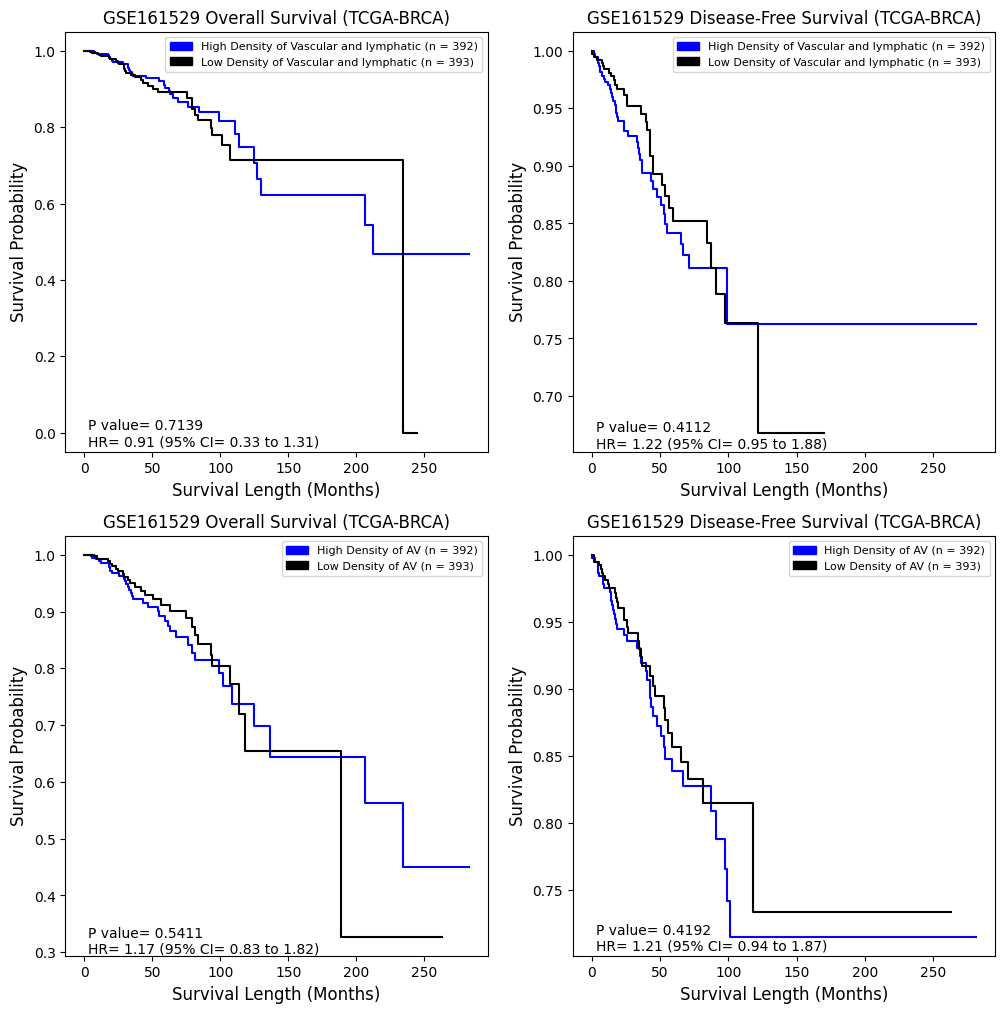

In [26]:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# subplot 1
cell_type = 'Vascular and lymphatic'
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "OS")
axs[0, 0].step(*kmf(E_high, S_high), c='b')
axs[0, 0].step(*kmf(E_low, S_low), c='k')
axs[0, 0].set_xlabel('Survival Length (Months)', fontsize=12)
axs[0, 0].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[0, 0].text(3,-0.035, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[0, 0].legend(handles=[high_patch,low_patch], fontsize=8)
axs[0, 0].set_title(f'GSE161529 Overall Survival (TCGA-BRCA)', fontsize=12)

# subplot 2
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "DFS")
axs[0, 1].step(*kmf(E_high, S_high), c='b')
axs[0, 1].step(*kmf(E_low, S_low), c='k')
axs[0, 1].set_xlabel('Survival Length (Months)', fontsize=12)
axs[0, 1].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[0, 1].text(3,0.655, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[0, 1].legend(handles=[high_patch,low_patch],fontsize=8)
axs[0, 1].set_title(f'GSE161529 Disease-Free Survival (TCGA-BRCA)', fontsize=12)

# subplot 3
cell_type = 'AV'
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "OS")
axs[1, 0].step(*kmf(E_high, S_high), c='b')
axs[1, 0].step(*kmf(E_low, S_low), c='k')
axs[1, 0].set_xlabel('Survival Length (Months)', fontsize=12)
axs[1, 0].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[1, 0].text(3,0.298, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[1, 0].legend(handles=[high_patch,low_patch], fontsize=8)
axs[1, 0].set_title(f'GSE161529 Overall Survival (TCGA-BRCA)', fontsize=12)

# subplot 4
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "DFS")
axs[1, 1].step(*kmf(E_high, S_high), c='b')
axs[1, 1].step(*kmf(E_low, S_low), c='k')
axs[1, 1].set_xlabel('Survival Length (Months)', fontsize=12)
axs[1, 1].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[1, 1].text(3,0.705, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[1, 1].legend(handles=[high_patch,low_patch],fontsize=8)
axs[1, 1].set_title(f'GSE161529 Disease-Free Survival (TCGA-BRCA)', fontsize=12)
path = "../figures/GSE161529/VA_AV_cell_survival_logranktest.png"
plt.savefig(path,format='png')
plt.show()
plt.close()

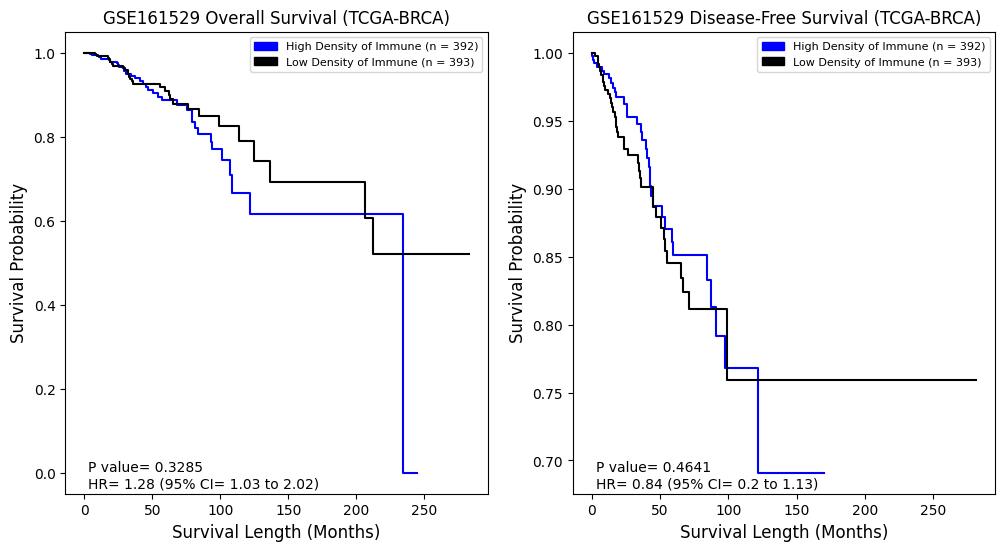

In [27]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# subplot 1
cell_type = 'Immune'
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "OS")

axs[0].step(*kmf(E_high, S_high), c='b')
axs[0].step(*kmf(E_low, S_low), c='k')
axs[0].set_xlabel('Survival Length (Months)', fontsize=12)
axs[0].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[0].text(3,-0.035, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[0].legend(handles=[high_patch,low_patch], fontsize=8)
axs[0].set_title(f'GSE161529 Overall Survival (TCGA-BRCA)', fontsize=12)

# subplot 2
S_high,S_low,E_high,E_low, cph  = generate_levels(survival_test, cell_type, "DFS")
axs[1].step(*kmf(E_high, S_high), c='b')
axs[1].step(*kmf(E_low, S_low), c='k')
axs[1].set_xlabel('Survival Length (Months)', fontsize=12)
axs[1].set_ylabel('Survival Probability', fontsize=12)
p, hr, ci_low, ci_high = retrieve_stats(cph)
msg = f"P value= {round(p,4)}\nHR= {round(hr,2)} (95% CI= {round(ci_low,2)} to {round(ci_high,2)})"
axs[1].text(3,0.68, msg,fontsize=10)
high_patch = mpatches.Patch(color='b',label=f'High Density of {cell_type} (n = {len(E_high)})')
low_patch = mpatches.Patch(color='k',label=f'Low Density of {cell_type} (n = {len(E_low)})')
axs[1].legend(handles=[high_patch,low_patch],fontsize=8)
axs[1].set_title(f'GSE161529 Disease-Free Survival (TCGA-BRCA)', fontsize=12)

path = "../figures/GSE161529/Immune_cell_survival_logranktest.png"
plt.savefig(path,format='png')
plt.show()
plt.close()